In [1]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/emotions-dataset-for-nlp/val.txt
/kaggle/input/emotions-dataset-for-nlp/test.txt
/kaggle/input/emotions-dataset-for-nlp/train.txt


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional,Dropout

import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup

In [3]:
test_data = pd.read_csv("../input/emotions-dataset-for-nlp/test.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
train_data = pd.read_csv("../input/emotions-dataset-for-nlp/train.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
validation_data = pd.read_csv("../input/emotions-dataset-for-nlp/val.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
print("Train : ", train_data.shape)
print("Test : ", test_data.shape)
print("Validation : ", validation_data.shape)

Train :  (16000, 2)
Test :  (2000, 2)
Validation :  (2000, 2)


In [4]:
train_data.head()

,Comment,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
train_data['length'] = [len(x) for x in train_data['Comment']]
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


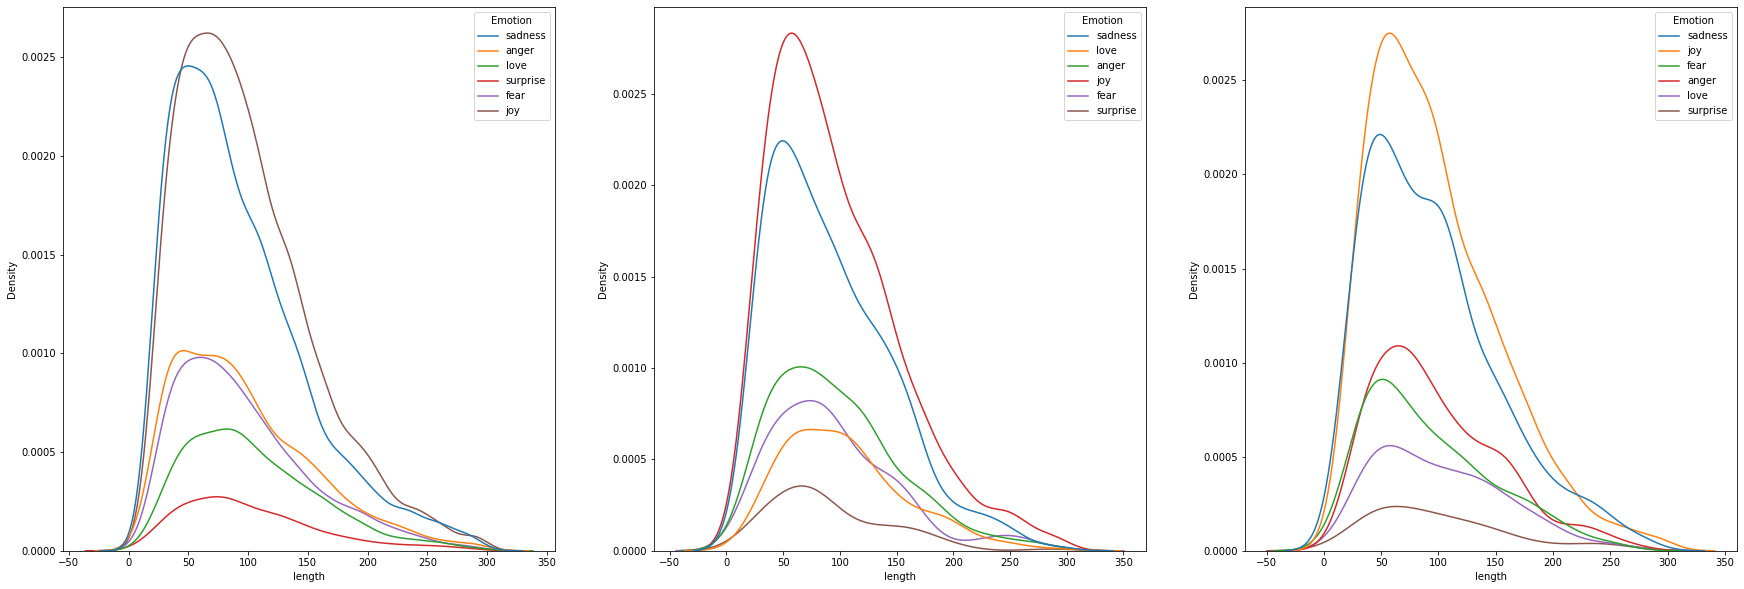

In [6]:
all_data = {'Train Data': train_data, 'Validation Data': validation_data, 'Test Data': test_data}
fig, ax = plt.subplots(1,3, figsize=(30,10))
for i, df in enumerate(all_data.values()):
    df2 = df.copy()
    df2['length'] = [len(x) for x in df2['Comment']]
    sns.kdeplot(data=df2,x='length',hue='Emotion', ax=ax[i])
plt.show()

In [7]:
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

### Words Cloud for each emotion

In [8]:
emotions_list = train_data['Emotion'].unique()
emotions_list

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

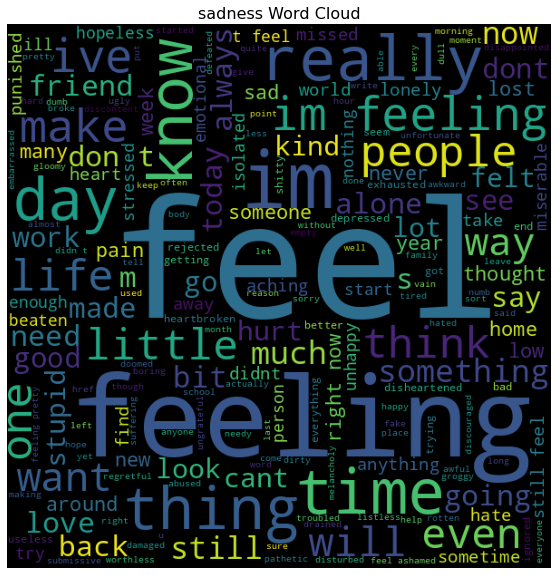

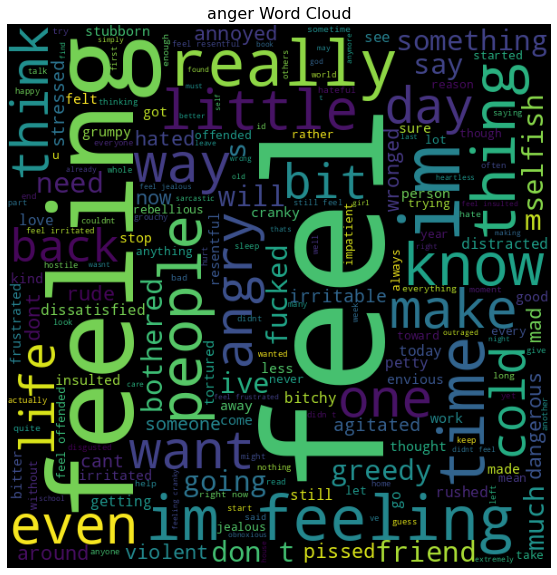

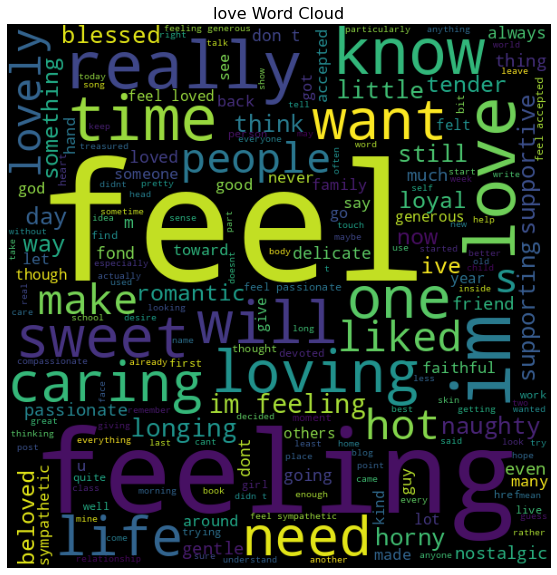

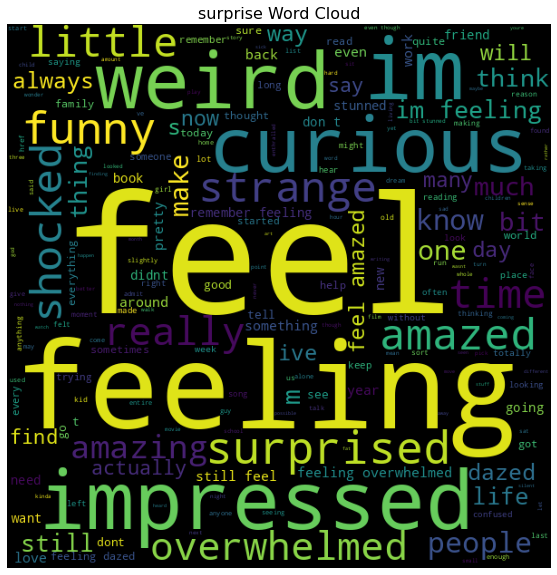

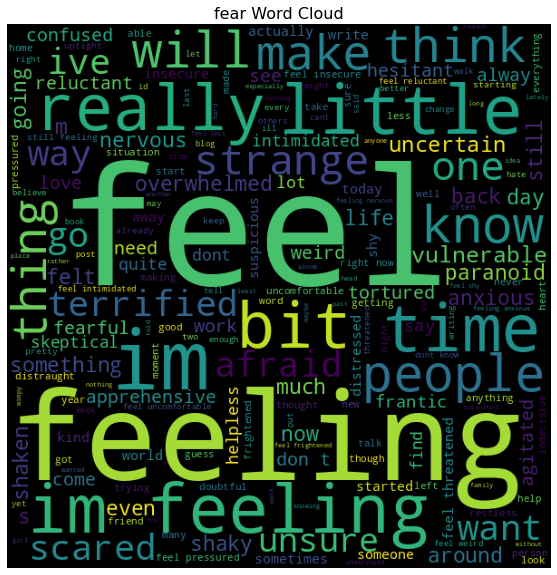

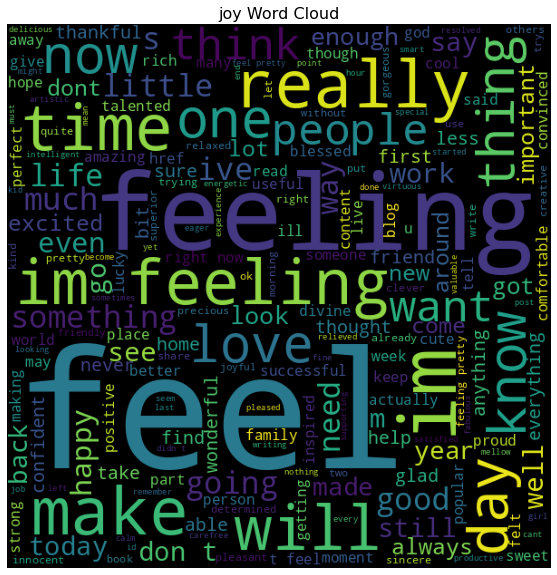

In [9]:
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

In [10]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])
test_data['Emotion'] = lb.fit_transform(test_data['Emotion'])
validation_data['Emotion'] = lb.fit_transform(validation_data['Emotion'])

# Preprocessing

In [11]:
train_data.head(2)

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108


In [12]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [13]:
max_len=train_data['length'].max()
max_len

300

In [14]:
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(pd.concat(X_train, axis=0))

In [15]:
vocabSize = 11000

In [16]:
from tensorflow.keras.preprocessing.text import one_hot
def text_cleaning(df, column):
    """Removing unrelevent chars, Stemming and padding"""
    stemmer = PorterStemmer()
    corpus = []
    
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    print(pad.shape)
    return pad

In [17]:
x_train = text_cleaning(train_data, "Comment")
x_test = text_cleaning(test_data, "Comment")
x_val = text_cleaning(validation_data, "Comment")

(16000, 300)
(2000, 300)
(2000, 300)


In [18]:
y_train = train_data["Emotion"]
y_test = test_data["Emotion"]
y_val = validation_data["Emotion"]

In [19]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Model building



In [20]:
model = Sequential()
model.add(Embedding(input_dim=vocabSize,output_dim=150,input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))


User settings:

   KMP_AFFINITY=granularity=fine,noverbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER

In [21]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 150)          1650000   
_________________________________________________________________
dropout (Dropout)            (None, 300, 150)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               142848    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3

In [22]:
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

In [23]:
hist = model.fit(x_train,y_train,epochs=10,batch_size=64,
                 validation_data=(x_val,y_val), verbose=1, callbacks=[callback])

Epoch 1/10


2022-07-01 08:38:09.798714: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


250/250 [==============================] - 117s 459ms/step - loss: 1.5002 - accuracy: 0.4050 - val_loss: 1.1498 - val_accuracy: 0.5860
Epoch 2/10
250/250 [==============================] - 113s 450ms/step - loss: 0.6475 - accuracy: 0.7901 - val_loss: 0.4321 - val_accuracy: 0.8555
Epoch 3/10
250/250 [==============================] - 114s 458ms/step - loss: 0.3244 - accuracy: 0.8946 - val_loss: 0.3657 - val_accuracy: 0.8825
Epoch 4/10
250/250 [==============================] - 113s 452ms/step - loss: 0.2210 - accuracy: 0.9292 - val_loss: 0.3467 - val_accuracy: 0.8920
Epoch 5/10
250/250 [==============================] - 113s 451ms/step - loss: 0.1649 - accuracy: 0.9464 - val_loss: 0.3274 - val_accuracy: 0.8910
Epoch 6/10
250/250 [==============================] - 113s 451ms/step - loss: 0.1303 - accuracy: 0.9561 - val_loss: 0.3219 - val_accuracy: 0.8895
Epoch 7/10
250/250 [==============================] - 113s 451ms/step - loss: 0.1104 - accuracy: 0.9614 - val_loss: 0.3952 - val_accura

In [24]:
model.evaluate(x_val,y_val,verbose=1)

63/63 [==============================] - 6s 92ms/step - loss: 0.3219 - accuracy: 0.8895


[0.32191550731658936, 0.8895000219345093]

In [25]:
model.evaluate(x_test,y_test,verbose=1)

63/63 [==============================] - 7s 103ms/step - loss: 0.3562 - accuracy: 0.8820


[0.3561752140522003, 0.8820000290870667]

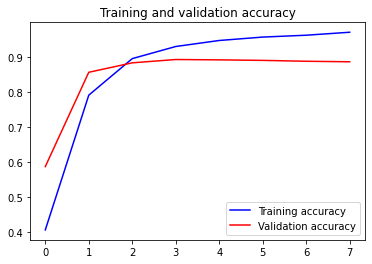

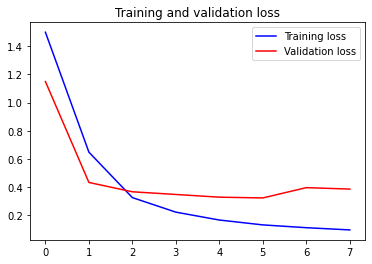

In [26]:
accuracy = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']
epochs=range(len(accuracy))

plt.plot(epochs,accuracy,'b', label='Training accuracy')
plt.plot(epochs,val_acc,'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'b', label='Training loss')
plt.plot(epochs,val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
def sentence_cleaning(sentence):
    """Pre-processing sentence for prediction"""
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    return pad

In [29]:
sentences = [
            "I am really happy today because I met him today",
            "I feel depressed"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

I am really happy today because I met him today
joy : 0.9047494530677795


I feel depressed
sadness : 0.9968103766441345


